## Setup

In [37]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain-ollama

In [13]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
response = requests.get(url)

if response.status_code == 200:
  with open("Chinook.db" , "wb") as file:
    file.write(response.content)

else:
  print(f"Failed to download the file. Status code :{response.status_code}")

In [14]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(f"Available tables : {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Available tables : ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
Sample output: [(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]


In [15]:
from langchain_ollama import ChatOllama


llm = ChatOllama(model="qwen3:1.7b")  # or "llama3", etc.


In [8]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db = db, llm = llm)
tools = toolkit.get_tools()

for tool in tools:
  print(f"{tool.name} : {tool.description}\n")

sql_db_query : Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema : Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables : Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker : Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



## Agent

In [16]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
Answer in English.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm , tools , prompt = system_prompt
)

In [17]:
question = "Which genre on average has the longest tracks?"

response = agent.invoke(
    {"messages": [{"role": "user", "content": question}]}
)
print(response["messages"][-1].content)


<think>
Okay, the user asked which genre has the longest average tracks. The query returned five entries with the genre names and their average track lengths. The top result is 'Sci Fi & Fantasy' with approximately 2,911,783 milliseconds. The next ones are 'Science Fiction' at 2,625,549, then 'Drama' at 2,575,283, 'TV Shows' at 2,145,041, and 'Comedy' at 1,585,263.

I need to present this in a clear way. The user probably wants the genre with the highest average first. Since the results are already ordered descending, I can just list them. But maybe highlight the top one. Let me check the numbers again to confirm the order. Yes, 'Sci Fi & Fantasy' is first. So the answer is that genre, followed by the others in order. I should mention the average duration for each to clarify. Also, note that the values are in milliseconds, so maybe convert them to seconds for better understanding, but the user didn't specify units, so keep it as is.
</think>

The genre with the longest average track le

In [18]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

<think>
Okay, let's tackle the question: "Which genre on average has the longest tracks?" 

First, I need to figure out which tables are involved. The user is asking about genres and their track lengths, so probably there's a table that lists genres and another that has track information. Since the tools include sql_db_schema, I should check the database schema to see the relevant tables.

I'll start by using sql_db_schema to get the schema of the most relevant tables. Let's assume the database has tables like 'genres' and 'tracks'. I'll call the schema function with these tables.

Once I have the schema, I can see the columns. For example, if the 'tracks' table has a 'length' column, that's where the track durations are. The 'genres' table might have a 'name' column. 

Next, I 

## Building Graph

In [19]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END,START, MessagesState , StateGraph
from langgraph.prebuilt import ToolNode

In [20]:
get_schema_tool = next(tool for tool in tools if tool.name == 'sql_db_schema')
get_schema_node = ToolNode([get_schema_tool] , name = "get_schema")

In [21]:
run_query_tool = next(tool for tool in tools if tool.name == 'sql_db_query')
run_query_node = ToolNode([run_query_tool],name = "run_query")

In [22]:
def list_tables (state : MessagesState) :
  tool_call = {
      "name" : "sql_db_list_tables",
      "args" :{},
      "id" : "a1234",
      "type" :"tool_call",

  }
  tool_call_message = AIMessage(content = "",tool_calls =[tool_call])
  list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
  tool_message = list_tables_tool.invoke(tool_call)
  response = AIMessage(f"Available tables: {tool_message.content}")

  return {"messages": [tool_call_message, tool_message, response]}



In [24]:
def call_get_schema(state: MessagesState):
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

In [25]:
generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


In [27]:
def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }

    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


In [28]:
check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


In [30]:
def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [31]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"

In [32]:
graph = StateGraph(MessagesState)
graph.add_node(list_tables)
graph.add_node(call_get_schema)
graph.add_node(get_schema_node, "get_schema")
graph.add_node(generate_query)
graph.add_node(check_query)
graph.add_node(run_query_node, "run_query")

graph.add_edge(START, "list_tables")
graph.add_edge("list_tables", "call_get_schema")
graph.add_edge("call_get_schema", "get_schema")
graph.add_edge("get_schema", "generate_query")
graph.add_conditional_edges(
    "generate_query",
    should_continue,
)
graph.add_edge("check_query", "run_query")
graph.add_edge("run_query", "generate_query")

agent = graph.compile()



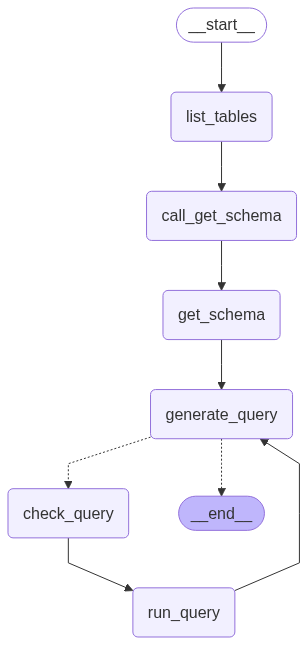

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [34]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

Available tables: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

.

The question is: Which genre on average has the longest tracks?

I need to find the average duration of tracks per genre.

First, I need to check the tables to see which ones have a duration field. Let's look at the tables:

- Album: No duration field.
- Artist: No duration field.
- Customer: No duration field.
- Employee: No duration field.
- Genre: No duration field.
- Invoice: No duration field.
- InvoiceLine: No duration field.
- MediaType: No duration field.
- Playlist: No duration field.
- PlaylistTrack: No duration field.
- Track: Has a duration field.

So, the only 

In [35]:
question = "Which genre on average has the longest tracks?"

response = agent.invoke(
    {"messages": [{"role": "user", "content": question}]}
)
print(response["messages"][-1].content)


<think>
Okay, the user asked which genre has the longest average tracks. The query returned five results sorted by average milliseconds in descending order. The top genre is 'Sci Fi & Fantasy' with approximately 2,911,783 milliseconds. Then 'Science Fiction' at 2,625,549, followed by 'Drama' at 2,575,283, 'TV Shows' at 2,145,041, and 'Comedy' at 1,585,263.

I need to present this in a clear way. The user might want to know the genre and the average duration. The answer should list the top genres first. Also, note that the values are in milliseconds, so converting them to seconds would be helpful. But since the user didn't ask for conversion, just the average, it's better to keep it in milliseconds. 

Check if the results are ordered correctly. The first entry is the longest, so that's correct. The limit is 5, which matches the response. No errors in the query, so the answer is accurate.
</think>

The genre with the longest average track duration is:

1. **Sci Fi & Fantasy** - Average: 